In [1]:

%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
pd.options.display.mpl_style = 'default'

import inspect, os
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir) 
from src.dashboard_helpers import Test, custom_amount_stats
from src.data_retrieval import *
from db_utils import query_hive_ssh
import copy


def doctor_payment_data(t, n_clicks, conversion_rate, average_donation, banner_name, method_name ):
    t = copy.deepcopy(t)
    donations = int(n_clicks * conversion_rate)
    clicks = t.data[banner_name]['clicks']
    clicks = clicks.reset_index()
    del clicks['timestamp']
    gw = pd.DataFrame([[0, method_name]]*n_clicks )
    gw.columns = ['impressions_seen', 'payment_method']
    t.data[banner_name]['clicks'] = pd.concat([clicks, gw], axis=0)

    dons = t.data[banner_name]['donations']
    dons = dons.reset_index()
    del dons['timestamp']
    gw = pd.DataFrame([[average_donation, 0, method_name]]*donations )
    gw.columns = ['amount', 'impressions_seen', 'payment_method']
    t.data[banner_name]['donations'] = pd.concat([dons, gw], axis=0)
    return t

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 28 days


In [3]:
hive_query = """
SELECT 
  a.banner,
  a.recurring,
  COUNT(*) as n 
FROM (
    SELECT
      PARSE_URL(CONCAT('http://bla.org/woo/', uri_query), 'QUERY', 'bannername') as banner,
      PARSE_URL(CONCAT('http://bla.org/woo/', uri_query), 'QUERY', 'recurring') as recurring
    FROM wmf.webrequest 
    WHERE year = 2015
      AND (month = 6 AND day = 5 AND hour in (12, 13, 14))
      AND ((webrequest_source = 'text') OR (webrequest_source = 'mobile'))
      AND uri_host = 'meta.wikimedia.org'
      AND uri_path = '/wiki/Special:RecordImpression'
      AND PARSE_URL(CONCAT('http://bla.org/woo/', uri_query), 'QUERY', 'paymentclick') = 'true'
      AND PARSE_URL(CONCAT('http://bla.org/woo/', uri_query), 'QUERY', 'paymentmethod') = 'google'
      AND length(PARSE_URL(CONCAT('http://bla.org/woo/', uri_query), 'QUERY', 'amount')) < 4
) a
GROUP BY
  a.banner,
  a.recurring
"""

d = query_hive_ssh(hive_query, 'googlequery')


In [4]:
d

,a.banner,a.recurring,n
0,B15_0605_enUS_mob_pm_gib_and,False,67
1,B15_0605_enUS_mob_pm_gib_ios,False,15


In [5]:
start = '2015-06-05 11:00'
end =  '2015-06-05 18:00'   
ctl_and = 'B15_0605_enUS_mob_pm_ctl_and'
ctl_ios = 'B15_0605_enUS_mob_pm_ctl_ios'
gib_and = 'B15_0605_enUS_mob_pm_gib_and'
gib_ios = 'B15_0605_enUS_mob_pm_gib_ios'

In [10]:
t = Test(ctl_and, ctl_ios,gib_and, gib_ios,  start=start, stop = end)

In [20]:
t.ecom()

,donations,impressions,dons/i,amount,amount/i,clicks,clicks/i,dons/clicks,amount_ro,amount_ro/i,max,median,avg,avg_ro
B15_0605_enUS_mob_pm_ctl_and,415,158800,0.002613,3175.00,0.019994,744,0.004685,0.557796,2975.00,0.018734,50,3,7.650602,7.238443
B15_0605_enUS_mob_pm_ctl_ios,469,238600,0.001966,5053.23,0.021179,858,0.003596,0.546620,4453.23,0.018664,100,3,10.774478,9.618207
B15_0605_enUS_mob_pm_gib_and,349,154000,0.002266,2728.00,0.017714,650,0.004221,0.536923,2378.00,0.015442,100,3,7.816619,6.932945
B15_0605_enUS_mob_pm_gib_ios,450,242200,0.001858,4117.00,0.016998,749,0.003092,0.600801,3817.00,0.015760,100,3,9.148889,8.539150


In [23]:
# Doctor the Click and Donation Counts
a_clicks = 67
a_conversion_rate = 0.63
a_average_donation = 6.8
t2 = doctor_payment_data(t, a_clicks, a_conversion_rate, a_average_donation, gib_and, 'gw' )
i_clicks = 15
i_conversion_rate = 0.60
i_average_donation = 9.0
t2 = doctor_payment_data(t2, i_clicks, i_conversion_rate, i_average_donation, gib_ios, 'gw' )

In [24]:
t2.ecom()

,donations,impressions,dons/i,amount,amount/i,clicks,clicks/i,dons/clicks,amount_ro,amount_ro/i,max,median,avg,avg_ro
B15_0605_enUS_mob_pm_ctl_and,415,158800,0.002613,3175.00,0.019994,744,0.004685,0.557796,2975.00,0.018734,50,3,7.650602,7.238443
B15_0605_enUS_mob_pm_ctl_ios,469,238600,0.001966,5053.23,0.021179,858,0.003596,0.546620,4453.23,0.018664,100,3,10.774478,9.618207
B15_0605_enUS_mob_pm_gib_and,391,154000,0.002539,3013.60,0.019569,717,0.004656,0.545328,2378.00,0.015442,100,3,7.707417,6.932945
B15_0605_enUS_mob_pm_gib_ios,459,242200,0.001895,4198.00,0.017333,764,0.003154,0.600785,3817.00,0.015760,100,3,9.145969,8.539150


In [22]:
t2.get_payment_method_details()

donations  clicks  conversion_rate  \
B15_0605_enUS_mob_pm_ctl_and amazon        136     205        66.341463   
                             cc             65     204        31.862745   
                             paypal        214     335        63.880597   
B15_0605_enUS_mob_pm_ctl_ios amazon        136     229        59.388646   
                             cc             86     230        37.391304   
                             paypal        247     399        61.904762   
B15_0605_enUS_mob_pm_gib_and amazon         94     147        63.945578   
                             cc             75     213        35.211268   
                             gw             42      67        62.686567   
                             paypal        180     290        62.068966   
B15_0605_enUS_mob_pm_gib_ios amazon        117     183        63.934426   
                             cc             68     169        40.236686   
                             gw              9      15        60.000000   
                             paypal        265     397        66.750630   

                                     percent clicked on  percent donated on  \
B15_0605_enUS_mob_pm_ctl_and amazon           27.553763           32.771084   
                             cc               27.419355           15.662651   
                             paypal           45.026882           51.566265   
B15_0605_enUS_mob_pm_ctl_ios amazon           26.689977           28.997868   
                             cc               26.806527           18.336887   
                             paypal           46.503497           52.665245   
B15_0605_enUS_mob_pm_gib_and amazon           20.502092           24.040921   
                             cc               29.707113           19.181586   
                             gw                9.344491           10.741688   
                             paypal           40.446304           46.035806   
B15_0605_enUS_mob_pm_gib_ios amazon           23.952880           25.490196   
                             cc               22.120419           14.814815   
                             gw                1.963351            1.960784   
                             paypal           51.963351           57.734205   

                                     total_amount  ave_amount_ro  
B15_0605_enUS_mob_pm_ctl_and amazon        986.00       6.611940  
                             cc            624.00       9.600000  
                             paypal       1565.00       6.910377  
B15_0605_enUS_mob_pm_ctl_ios amazon       1451.00       9.335821  
                             cc           1256.00      12.571429  
                             paypal       2346.23       8.760122  
B15_0605_enUS_mob_pm_gib_and amazon        651.00       6.462366  
                             cc            886.00       8.371429  
                             gw            285.60            NaN  
                             paypal       1191.00       6.616667  
B15_0605_enUS_mob_pm_gib_ios amazon        875.00       7.478632  
                             cc            741.00       8.196970  
                             gw             81.00            NaN  
                             paypal       2501.00       9.094697

#Clicks per Impression

##Android

,P(Winner),Winners Lift,CI
B15_0605_enUS_mob_pm_ctl_and,0.54828,"(0.00%, 0.00%)","(0.004360, 0.005034)"
B15_0605_enUS_mob_pm_gib_and,0.45172,"(-9.15%, 11.42%)","(0.004329, 0.005008)"


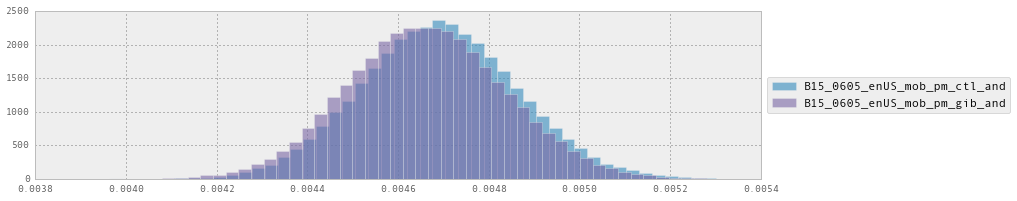

In [15]:
t2.rate_stats(ctl_and, gib_and, rate = 'clicks/impressions', conf = 95)

## IOS

,P(Winner),Winners Lift,CI
B15_0605_enUS_mob_pm_ctl_ios,0.99564,"(0.00%, 0.00%)","(0.003364, 0.003845)"
B15_0605_enUS_mob_pm_gib_ios,0.00436,"(3.35%, 25.71%)","(0.002941, 0.003384)"


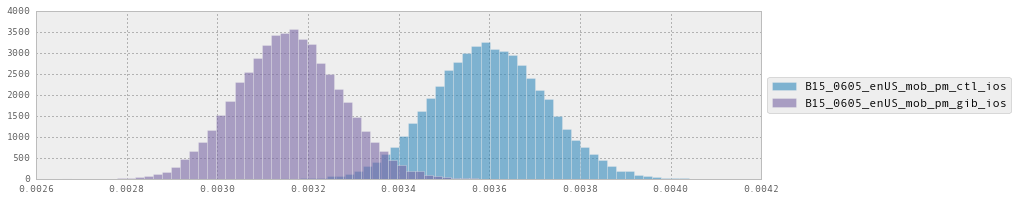

In [16]:
t2.rate_stats(ctl_ios, gib_ios, rate = 'clicks/impressions', conf = 95)

#Donations per Impression

## Android

,P(Winner),Winners Lift,CI
B15_0605_enUS_mob_pm_ctl_and,0.65728,"(0.00%, 0.00%)","(0.002374, 0.002876)"
B15_0605_enUS_mob_pm_gib_and,0.34272,"(-10.34%, 18.09%)","(0.002299, 0.002804)"


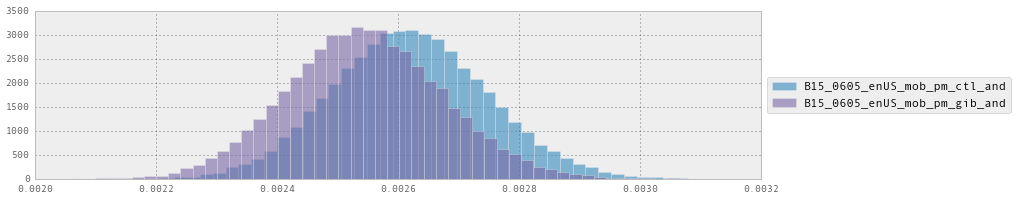

In [17]:
t2.rate_stats(ctl_and, gib_and, rate = 'donations/impressions', conf = 95)

##IOS

### Donations per impression

,P(Winner),Winners Lift,CI
B15_0605_enUS_mob_pm_ctl_ios,0.71212,"(0.00%, 0.00%)","(0.001795, 0.002151)"
B15_0605_enUS_mob_pm_gib_ios,0.28788,"(-8.77%, 17.87%)","(0.001731, 0.002075)"


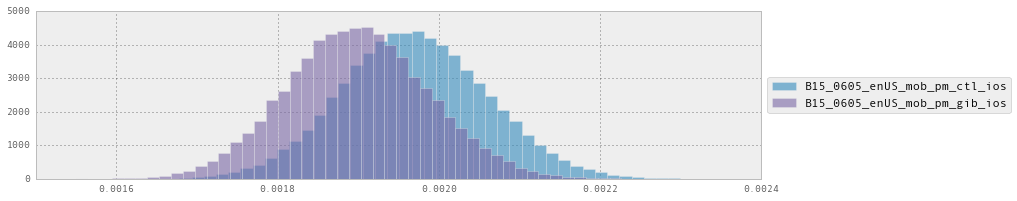

In [18]:
t2.rate_stats(ctl_ios, gib_ios, rate = 'donations/impressions', conf = 95)

# Amount Per Impression

## Android

Counter({3.0: 263, 15.0: 83, 20.0: 39, 5.0: 15, 10.0: 7, 50.0: 4, 1.0: 2, 6.0: 1, 8.0: 1})


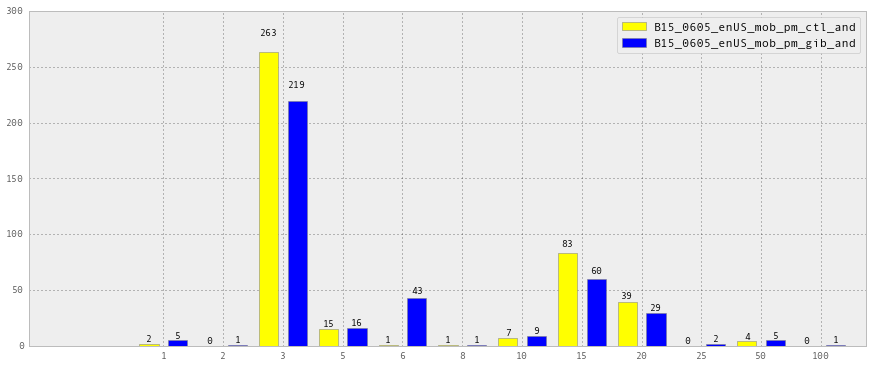

In [26]:
t2.compare_donation_amounts(ctl_and, gib_and )

Values for banner  B15_0605_enUS_mob_pm_ctl_and : [3.0, 15.0, 20.0, 5.0]
Values for banner  B15_0605_enUS_mob_pm_gib_and : [3.0, 15.0, 6.7999999999999998, 20.0, 5.0]


,P(Winner),Winners Lift,CI
B15_0605_enUS_mob_pm_ctl_and,0.87296,"(0.00%, 0.00%)","(0.016152, 0.020987)"
B15_0605_enUS_mob_pm_gib_and,0.12704,"(-7.39%, 34.35%)","(0.014447, 0.018876)"


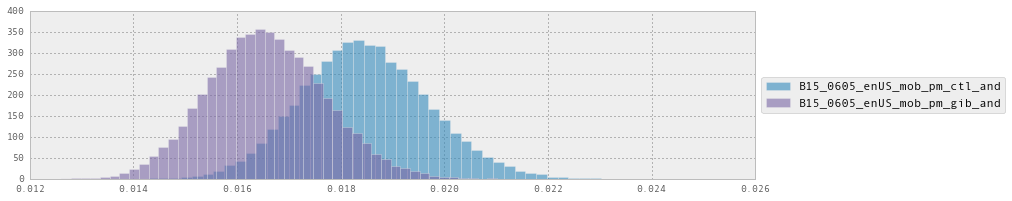

In [29]:
values = {
ctl_and: 4,
gib_and: 5
}

t2.amount_stats( values, conf = 95, rate = 'donations/impressions')

## IOS

Counter({3.0: 260, 15.0: 113, 20.0: 57, 50.0: 13, 10.0: 8, 100.0: 6, 5.0: 5, 1.0: 2, 2.0: 2, 17.0: 1, 35.0: 1, 25.0: 1})


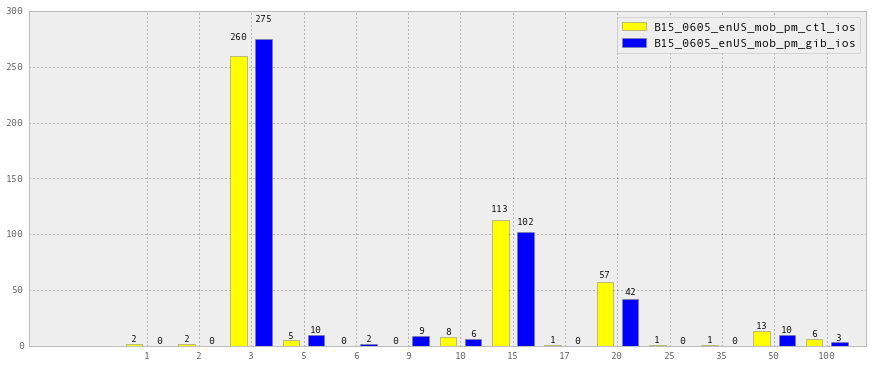

In [30]:
t2.compare_donation_amounts(ctl_ios, gib_ios )

Values for banner  B15_0605_enUS_mob_pm_gib_ios : [3.0, 15.0, 20.0]
Values for banner  B15_0605_enUS_mob_pm_ctl_ios : [3.0, 15.0, 20.0]


,P(Winner),Winners Lift,CI
B15_0605_enUS_mob_pm_ctl_ios,0.9372,"(0.00%, 0.00%)","(0.013509, 0.017216)"
B15_0605_enUS_mob_pm_gib_ios,0.0628,"(-3.71%, 36.48%)","(0.011737, 0.015072)"


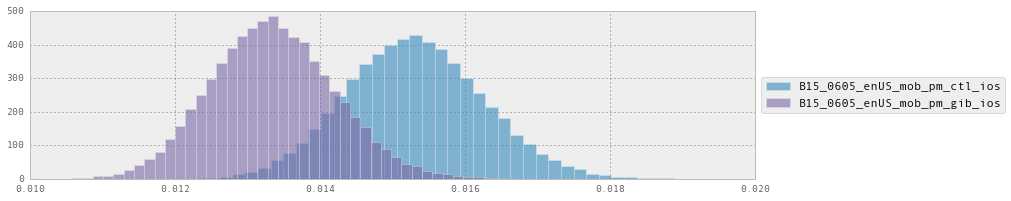

In [31]:
values = {
ctl_ios: 3,
gib_ios: 3
}

t2.amount_stats( values, conf = 95, rate = 'donations/impressions')